In [38]:
import requests
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import ta

Se crean las funciones para poder extraer la informacion necesaria.

In [41]:
import requests
import pandas as pd

def get_top_crypto_ids(limit=10):
    """
    Obtiene los IDs de las principales criptomonedas según su capitalización de mercado.

    Parámetros:
        limit (int): Número máximo de criptomonedas a obtener.

    Retorna:
        crypto_ids (list): Lista de IDs de las criptomonedas.
    """
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": limit,
        "page": 1,
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        crypto_ids = [crypto["id"] for crypto in data]
        return crypto_ids
    else:
        print("Error al obtener la lista de criptomonedas")
        return []

def get_crypto_price_history(crypto_id):
    """
    Obtiene el historial de precios de una criptomoneda en particular.

    Parámetros:
        crypto_id (str): ID de la criptomoneda.

    Retorna:
        data (dict): Datos del historial de precios de la criptomoneda.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "max", # Ingresamos max para evitar nulos
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error al obtener datos de la API para {crypto_id}")
        return None

def get_top_crypto_data(num_coins):
    """
    Obtiene información detallada de las principales criptomonedas según su capitalización de mercado.

    Parámetros:
        num_coins (int): Número de criptomonedas principales a obtener.

    Retorna:
        crypto_df (DataFrame): DataFrame con la información de las criptomonedas.
    """
    url_top_coins = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page={num_coins}&page=1"
    response_top_coins = requests.get(url_top_coins)
    top_coins_info = response_top_coins.json()

    crypto_data = []

    for coin_info in top_coins_info:
        coin_name = coin_info.get('name')
        coin_id = coin_info.get('id')
        max_supply = coin_info.get('max_supply', None)
        circulating_supply = coin_info.get('circulating_supply', None)
        current_price = coin_info.get('current_price', None)
        price_change_24h = coin_info.get('price_change_percentage_24h', None)
        market_cap_rank = coin_info.get('market_cap_rank', None)
        market_cap = coin_info.get('market_cap', None)
        volume_24h = coin_info.get('total_volume', None)

        crypto_data.append({
            'Coin': coin_name,
            'Max Supply': max_supply,
            'Circulating Supply': circulating_supply,
            'Current Price (USD)': current_price,
            'Price Change 24h (%)': price_change_24h,
            'Market Cap Rank': market_cap_rank,
            'Market Cap (USD)': market_cap,
            'Volume 24h (USD)': volume_24h,
            'CoinGecko ID': coin_id,
        })
    crypto_df = pd.DataFrame(crypto_data)
    return crypto_df





Obtenemos datos historicos de las top 10 cryptomonedas con mayor capitalizacion, ingresamos en el parametro days "max" para que me entregue la informacion de la fecha de creacion de cada crypto hasta hoy y asi evitar datos nulos.

In [42]:
# Obtiene los IDs de las 10 principales criptomonedas
top_crypto_ids = get_top_crypto_ids(limit=10)

# Lista para almacenar los datos procesados de las criptomonedas
crypto_data = []

# Itera sobre cada ID de criptomoneda
for crypto_id in top_crypto_ids:
    # Obtiene el historial de precios para la criptomoneda actual
    historial_crypto = get_crypto_price_history(crypto_id)
    
    # Si se obtuvo el historial exitosamente
    if historial_crypto:
        # Extrae las marcas de tiempo, precios, volúmenes y capitalizaciones de mercado
        timestamps = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in historial_crypto["prices"]]
        prices = [price for _, price in historial_crypto["prices"]]
        volumes = [volume for _, volume in historial_crypto["total_volumes"]]
        market_caps = [market_cap for _, market_cap in historial_crypto["market_caps"]]
        
        # Agrega los datos de la criptomoneda actual a la lista crypto_data
        crypto_data.append({
            "Crypto": crypto_id.capitalize(),
            "Timestamp": timestamps,
            "Price": prices,
            "Volume": volumes,
            "Market Cap": market_caps
        })

# Combina los datos de las criptomonedas en un DataFrame
df = pd.concat([pd.DataFrame(data) for data in crypto_data], ignore_index=True)

# Ordena el DataFrame por Criptomoneda y marca de tiempo
df = df.sort_values(by=['Crypto', 'Timestamp'])

# Calcula la variación porcentual del precio por día para cada Criptomoneda
df['Variación_Precio'] = df.groupby('Crypto')['Price'].pct_change()

# Rellena valores infinitos o NaN en la columna de variación con 0
df['Variación_Precio'] = df['Variación_Precio'].fillna(0)

# Muestra el DataFrame resultante con los datos procesados
df['SMA50'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.trend.SMAIndicator(x, window=50).sma_indicator())
df['SMA100'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.trend.SMAIndicator(x, window=100).sma_indicator())

df




Error al obtener la lista de criptomonedas


ValueError: No objects to concatenate

Obtenemos los datos en tiempo real de las 10 cryptomonedas con mayor capitalizacion 

In [4]:
# Obtener los datos de las 10 principales criptomonedas utilizando una función llamada get_top_crypto_data
top_crypto_df = get_top_crypto_data(10)
top_crypto_df


,Coin,Max Supply,Circulating Supply,Current Price (USD),Price Change 24h (%),Market Cap Rank,Market Cap (USD),Volume 24h (USD),CoinGecko ID
0,Bitcoin,2.100000e+07,1.945838e+07,29158.000000,-0.57916,1,567220150418,11369874631,bitcoin
1,Ethereum,NaN,1.201422e+08,1825.150000,-0.86596,2,219242327604,5158061678,ethereum
2,Tether,NaN,8.341087e+10,0.999194,0.04546,3,83343605799,10555081949,tether
3,BNB,2.000000e+08,1.538562e+08,236.040000,-1.63266,4,36288160550,403532761,binancecoin
4,XRP,1.000000e+11,5.278728e+10,0.603228,-3.91130,5,31826627704,1129273838,ripple
5,USD Coin,NaN,2.594305e+10,1.000000,0.03193,6,25945493103,3110935588,usd-coin
6,Lido Staked Ether,8.127994e+06,8.127893e+06,1822.990000,-0.89194,7,14816557590,18089089,staked-ether
7,Dogecoin,NaN,1.406038e+11,0.071039,-4.17655,8,9991930051,537717607,dogecoin
8,Cardano,4.500000e+10,3.504502e+10,0.280869,-2.98117,9,9844458519,161080916,cardano
9,Solana,NaN,4.061001e+08,24.010000,-3.23677,10,9746291398,409270141,solana


No tenemos Nulos por ende no sera necesario la limpieza de este df

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25209 entries, 9764 to 17359
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Crypto            25209 non-null  object        
 1   Timestamp         25209 non-null  datetime64[ns]
 2   Price             25209 non-null  float64       
 3   Volume            25209 non-null  float64       
 4   Market Cap        25206 non-null  float64       
 5   Variación_Precio  25209 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.3+ MB


Se puede observar que todas las altcoins siguen la fructuacion de bitcoin, esto quiere decir que depenten de el precio de bitcoin. Hay casos de altcoins que en la bajada de bitcoin tienen un piso solido en comparacion con otras que bajan hasta su precio mas bajo.

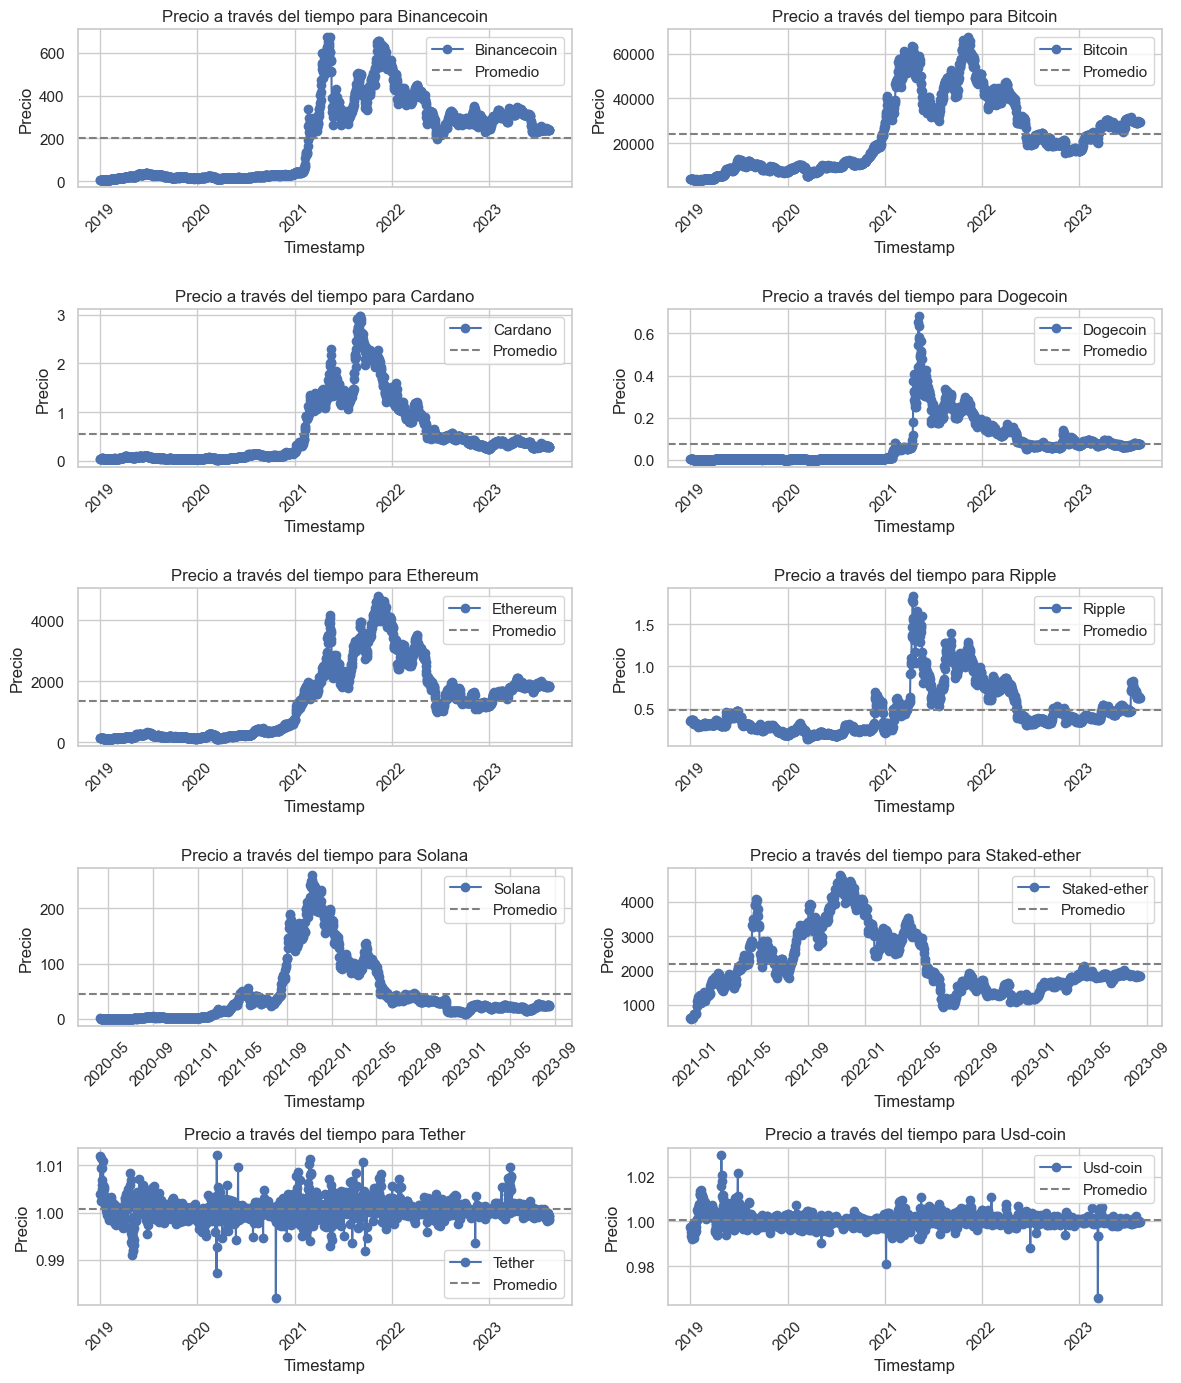

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que df contiene tus datos y tienes una columna 'Timestamp' en formato de fecha
# Convierte la columna 'Timestamp' a tipo datetime si aún no lo está
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtra los datos para incluir solo los registros a partir de 2019
df = df[df['Timestamp'].dt.year >= 2019]

unique_cryptos = df['Crypto'].unique()  # Obtén la lista de criptomonedas únicas

# Calcula el número de filas y columnas para la cuadrícula
num_cols = 2  # Puedes ajustar el número de columnas según tus preferencias
num_rows = -(-len(unique_cryptos) // num_cols)  # Redondeo hacia arriba de la división

# Crea la cuadrícula de subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 14))  # Ajusta el tamaño según tus preferencias

# Itera a través de las criptomonedas y los subplots correspondientes
for i, crypto_name in enumerate(unique_cryptos):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    crypto_data = df[df['Crypto'] == crypto_name]
    ax.plot(crypto_data['Timestamp'], crypto_data['Price'], label=crypto_name, marker='o')
    
    # Calcula y agrega la línea de promedio del precio
    average_price = crypto_data['Price'].mean()
    ax.axhline(y=average_price, color='gray', linestyle='--', label='Promedio')
    
    ax.set_title(f'Precio a través del tiempo para {crypto_name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Precio')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)  # Rotación de las etiquetas en el eje x
    ax.grid(True)

# Ajusta el espaciado entre los subplots y muestra el gráfico
plt.tight_layout()
plt.show()


C:\Users\sarau\AppData\Local\Temp\ipykernel_2524\414825440.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


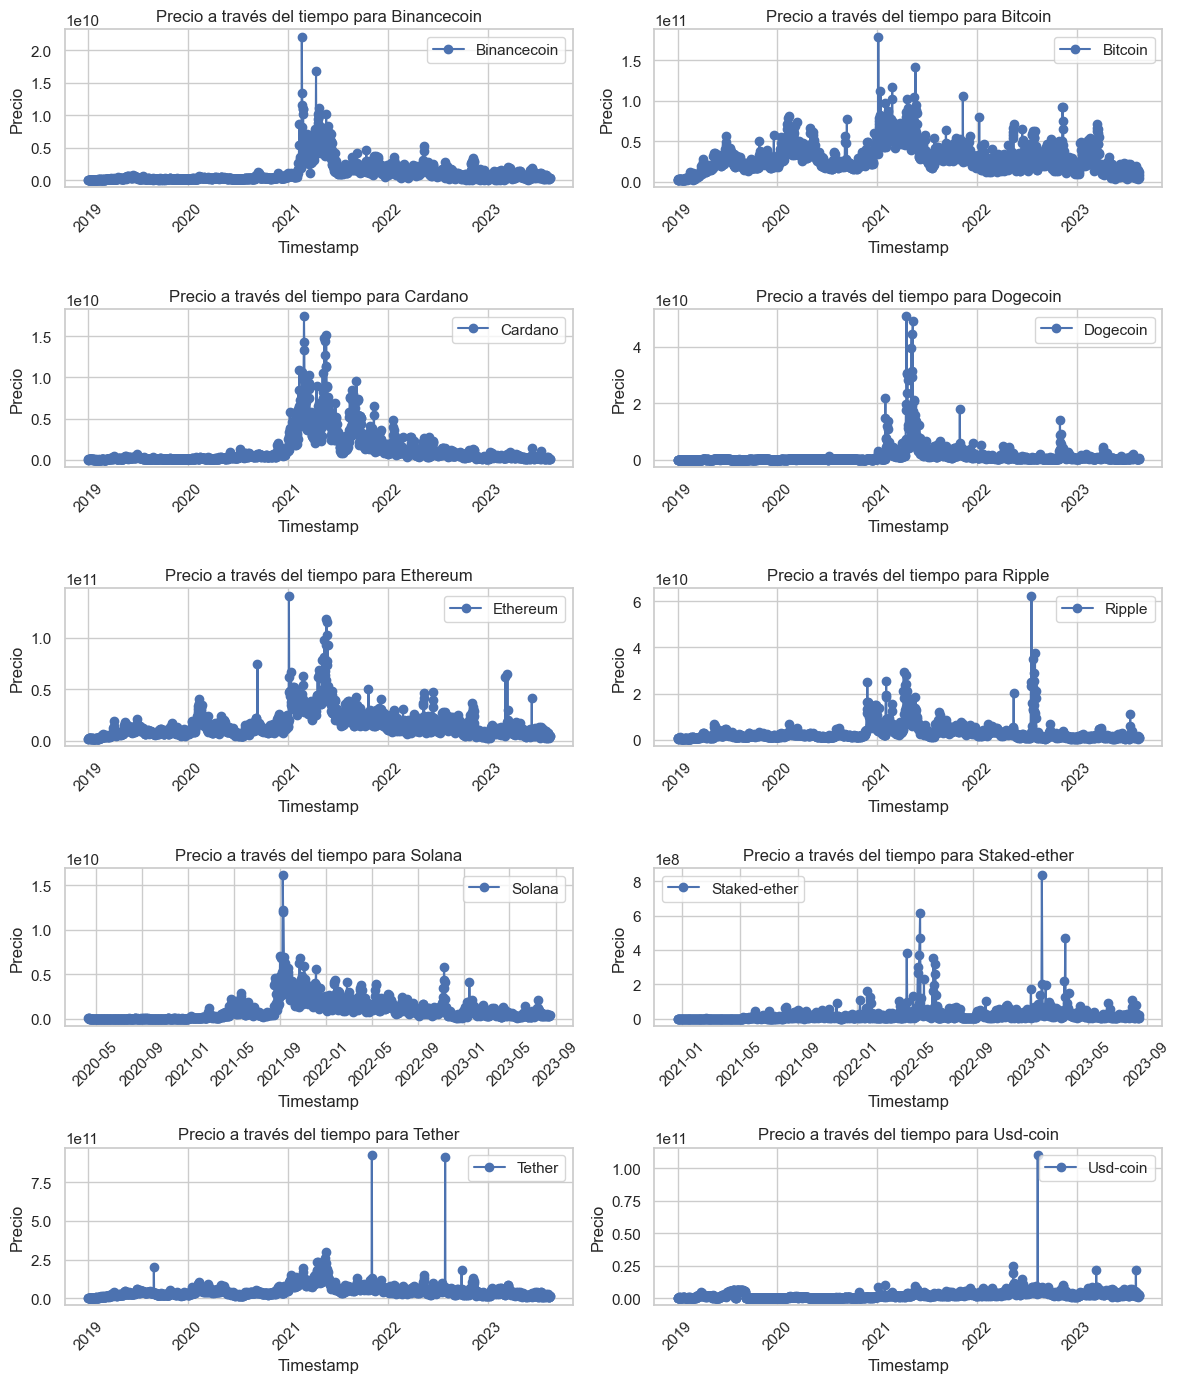

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que df contiene tus datos y tienes una columna 'Timestamp' en formato de fecha
# Convierte la columna 'Timestamp' a tipo datetime si aún no lo está
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtra los datos para incluir solo los registros a partir de 2018
df = df[df['Timestamp'].dt.year >= 2019]

unique_cryptos = df['Crypto'].unique()  # Obtén la lista de criptomonedas únicas

# Calcula el número de filas y columnas para la cuadrícula
num_cols = 2  # Puedes ajustar el número de columnas según tus preferencias
num_rows = -(-len(unique_cryptos) // num_cols)  # Redondeo hacia arriba de la división

# Crea la cuadrícula de subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 14))  # Ajusta el tamaño según tus preferencias

# Itera a través de las criptomonedas y los subplots correspondientes
for i, crypto_name in enumerate(unique_cryptos):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    crypto_data = df[df['Crypto'] == crypto_name]
    ax.plot(crypto_data['Timestamp'], crypto_data['Volume'], label=crypto_name, marker='o')
    ax.set_title(f'Precio a través del tiempo para {crypto_name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Precio')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)  # Rotación de las etiquetas en el eje x
    ax.grid(True)

# Ajusta el espaciado entre los subplots y muestra el gráfico
plt.tight_layout()
plt.show()

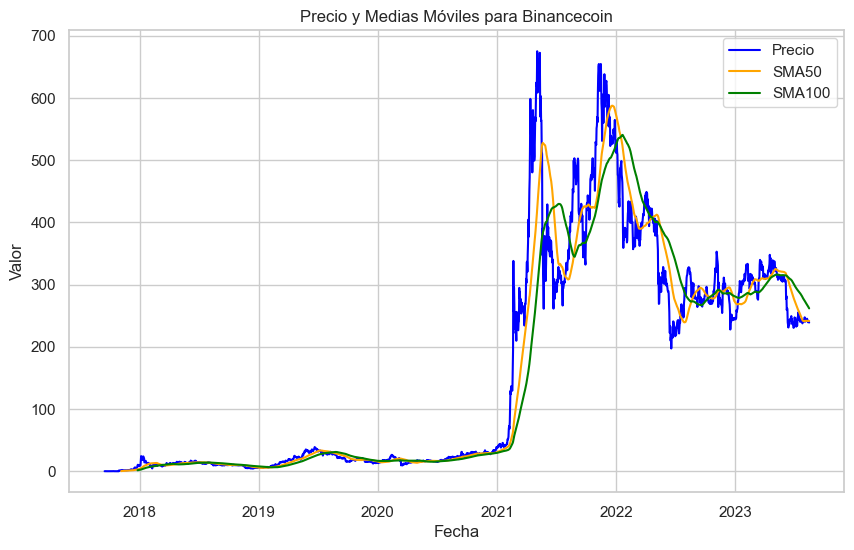

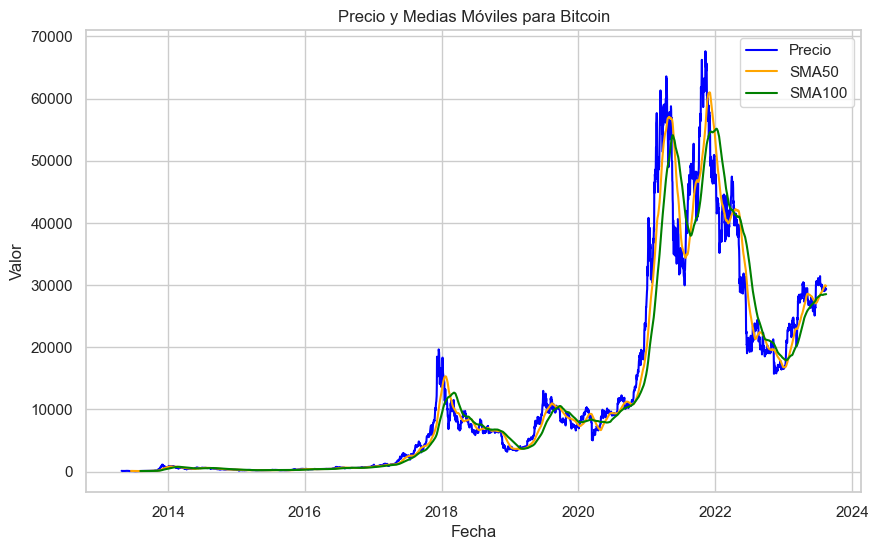

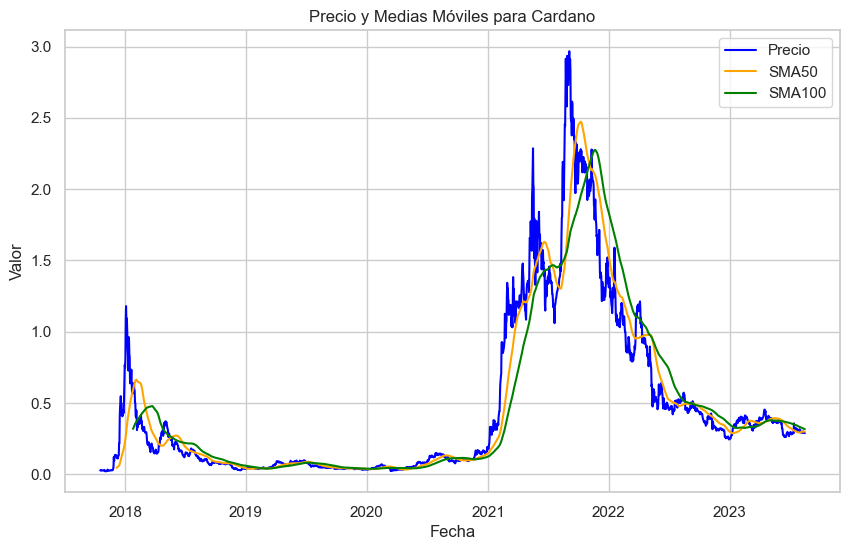

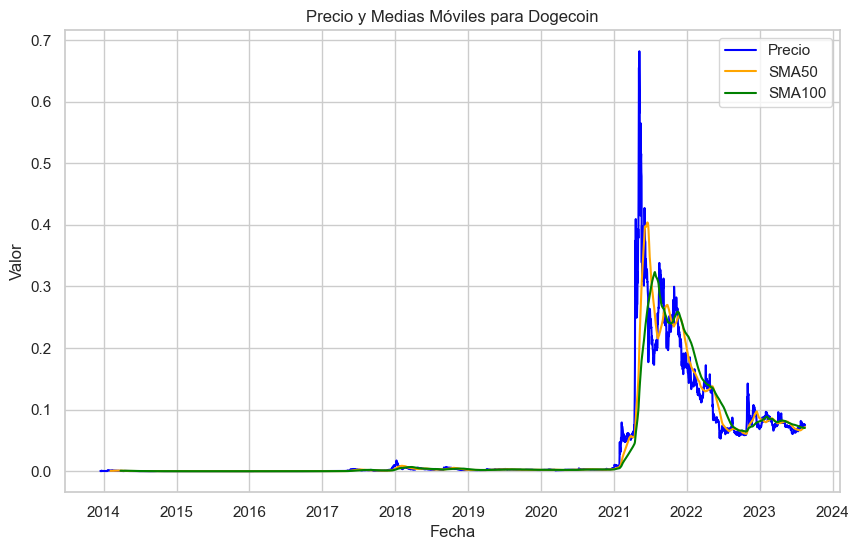

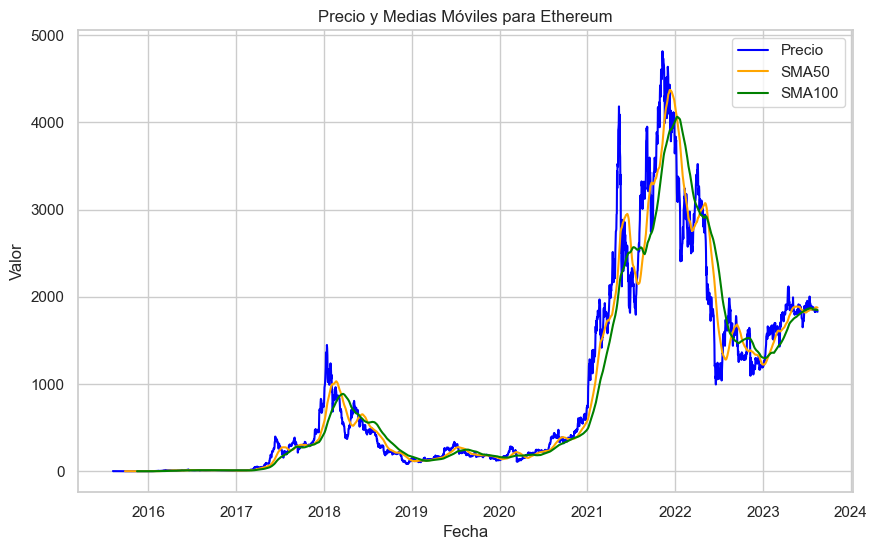

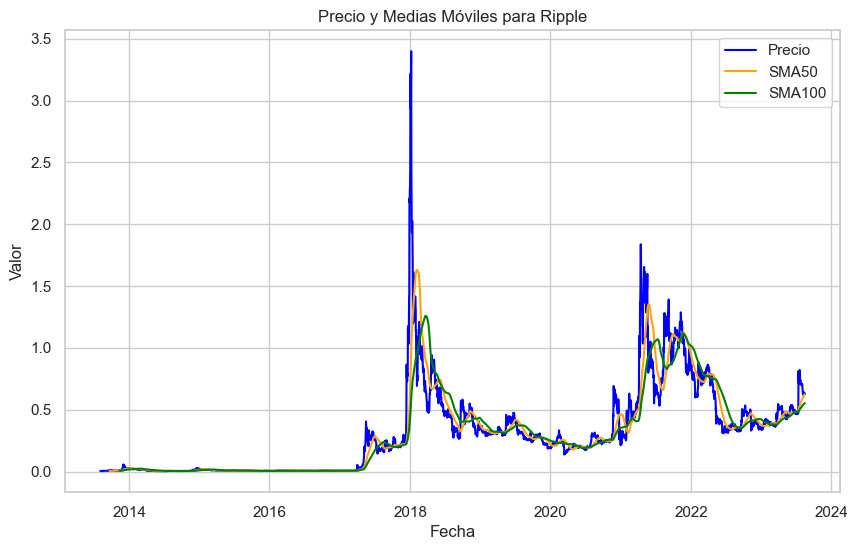

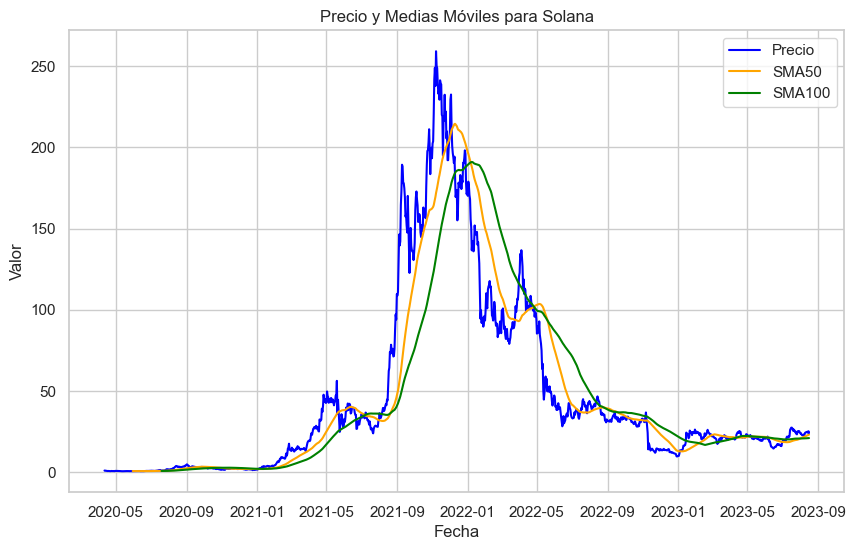

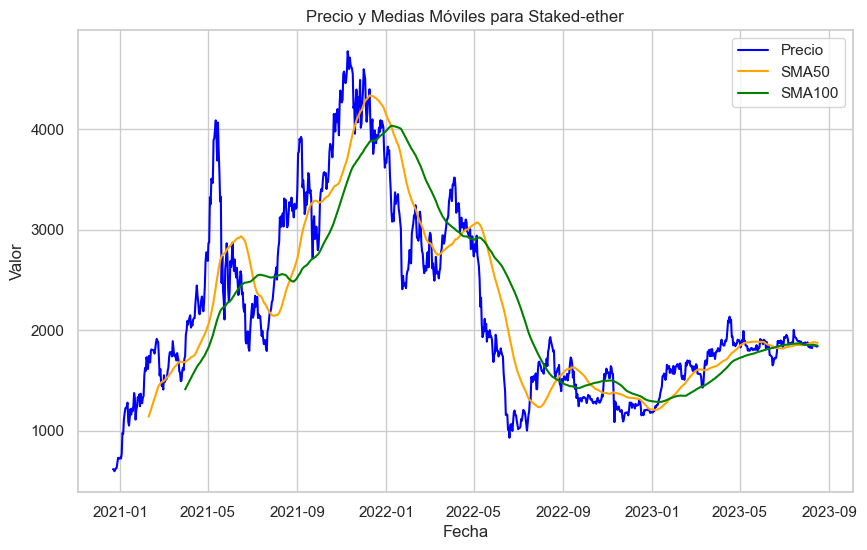

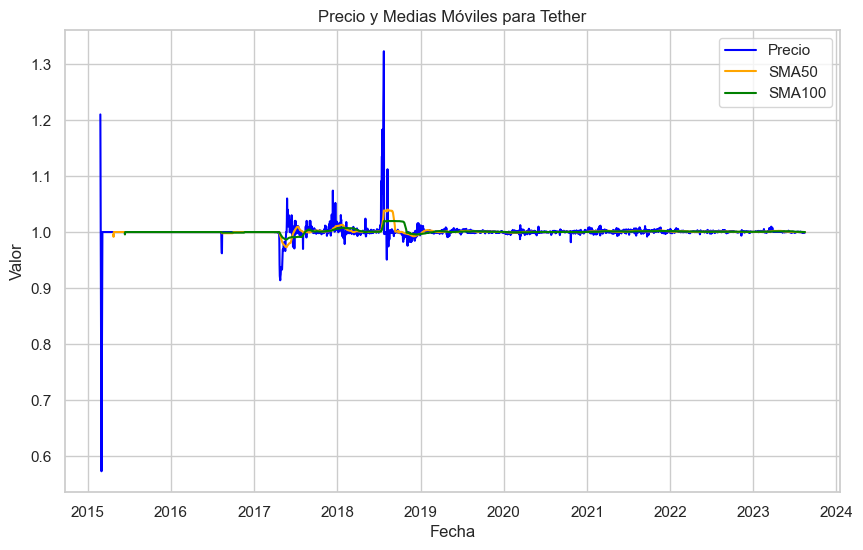

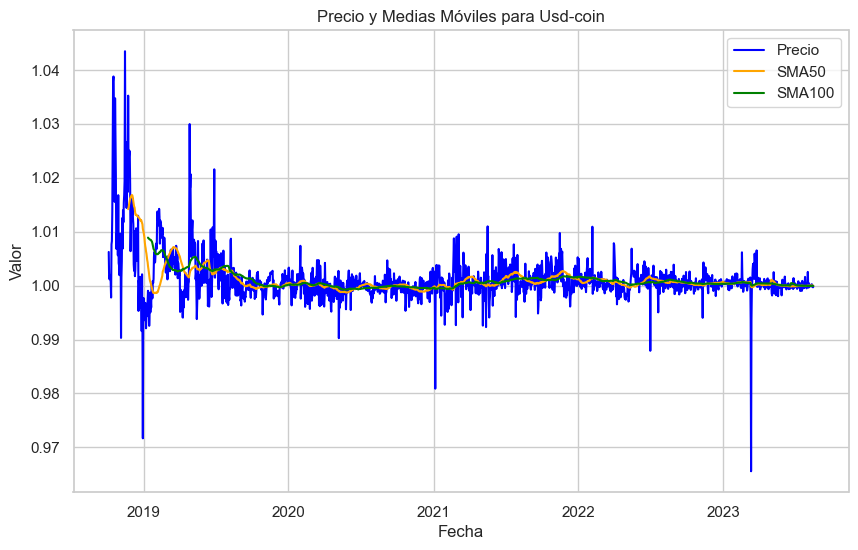

In [31]:
import matplotlib.pyplot as plt

# Función para graficar el precio y las medias móviles de una criptomoneda
def plot_crypto_price_with_smavgs(crypto_df):
    plt.figure(figsize=(10, 6))
    plt.plot(crypto_df['Timestamp'], crypto_df['Price'], label='Precio', color='blue')
    plt.plot(crypto_df['Timestamp'], crypto_df['SMA50'], label='SMA50', color='orange')
    plt.plot(crypto_df['Timestamp'], crypto_df['SMA100'], label='SMA100', color='green')
    plt.title(f"Precio y Medias Móviles para {crypto_df['Crypto'].iloc[0]}")
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

# Itera sobre cada criptomoneda y grafica sus datos
for crypto_name in df['Crypto'].unique():
    crypto_df = df[df['Crypto'] == crypto_name]
    plot_crypto_price_with_smavgs(crypto_df)


In [37]:
import requests
import pandas as pd
import ta

def get_top_crypto_ids(limit=10):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": limit,  # Use the provided limit parameter
        "page": 1,
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        crypto_ids = [crypto["id"] for crypto in data]
        return crypto_ids
    else:
        print("Error al obtener la lista de criptomonedas")
        return []

def get_crypto_price_history(crypto_id):
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "max",
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error al obtener datos de la API para {crypto_id}")
        return None

top_crypto_ids = get_top_crypto_ids(limit=10)
crypto_data = []

for crypto_id in top_crypto_ids:
    historial_crypto = get_crypto_price_history(crypto_id)
    if historial_crypto:
        timestamps = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in historial_crypto["prices"]]
        prices = [price for _, price in historial_crypto["prices"]]
        volumes = [volume for _, volume in historial_crypto["total_volumes"]]
        market_caps = [market_cap for _, market_cap in historial_crypto["market_caps"]]
        
        crypto_data.append({
            "Crypto": crypto_id.capitalize(),
            "Timestamp": timestamps,
            "Price": prices,
            "Volume": volumes,
            "Market Cap": market_caps
        })

# Create a final DataFrame with all the data
df = pd.concat([pd.DataFrame(data) for data in crypto_data], ignore_index=True)
# Ordena los datos por Criptomoneda y fecha para asegurarte de que estén en el orden correcto
df = df.sort_values(by=['Crypto', 'Timestamp'])

# Calcula la variación del precio por día para cada Criptomoneda
df['Variación_Precio'] = df.groupby('Crypto')['Price'].pct_change()

# Si lo deseas, puedes reemplazar los valores infinitos o NaN con 0 en la columna de variación
df['Variación_Precio'] = df['Variación_Precio'].fillna(0)

# Muestra el DataFrame resultante con los datos procesados
df['SMA50'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.trend.SMAIndicator(x, window=50).sma_indicator())
df['SMA100'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.trend.SMAIndicator(x, window=100).sma_indicator())

df

Error al obtener la lista de criptomonedas


ValueError: No objects to concatenate